In [89]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # Displays a progress bar
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, Subset, DataLoader, random_split
import math

In [3]:
# Load the dataset and train, val, test splits
print("Loading datasets...")
dataset_path = "C:/Users/Admin/Desktop/cse803_hw5"

MNIST_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.1307], [0.3081])
])
MNIST_train = datasets.MNIST(
    dataset_path,
    download=True,
    train=True,
    transform=MNIST_transform
)
MNIST_test = datasets.MNIST(
    dataset_path,
    download=True,
    train = False,
    transform=MNIST_transform
)

FASHION_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.2859], [0.3530])
])
FASHION_train = datasets.FashionMNIST(
    dataset_path,
    download=True,
    train=True,
    transform=MNIST_transform
)
FASHION_test = datasets.FashionMNIST(
    dataset_path,
    download=True,
    train=False,
    transform=FASHION_transform
)


Loading datasets...
Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|████████████████████████████████████████| 9912422/9912422 [00:02<00:00, 4386004.32it/s]


Extracting C:/Users/Admin/Desktop/cse803_hw5\MNIST\raw\train-images-idx3-ubyte.gz to C:/Users/Admin/Desktop/cse803_hw5\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|█████████████████████████████████████████████| 28881/28881 [00:00<00:00, 925045.96it/s]

Extracting C:/Users/Admin/Desktop/cse803_hw5\MNIST\raw\train-labels-idx1-ubyte.gz to C:/Users/Admin/Desktop/cse803_hw5\MNIST\raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 6664769.54it/s]


Extracting C:/Users/Admin/Desktop/cse803_hw5\MNIST\raw\t10k-images-idx3-ubyte.gz to C:/Users/Admin/Desktop/cse803_hw5\MNIST\raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|███████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]

Extracting C:/Users/Admin/Desktop/cse803_hw5\MNIST\raw\t10k-labels-idx1-ubyte.gz to C:/Users/Admin/Desktop/cse803_hw5\MNIST\raw



In [6]:
"""
Data Loaders.
"""
class GridDataset(Dataset):
    def __init__(self, MNIST_dataset, FASHION_dataset): # pass in dataset
        assert len(MNIST_dataset) == len(FASHION_dataset)
        self.MNIST_dataset, self.FASHION_dataset = MNIST_dataset, FASHION_dataset
        self.targets = FASHION_dataset.targets
        torch.manual_seed(442) # Fix random seed for reproducibility
        N = len(MNIST_dataset)
        self.randpos = torch.randint(low=0,high=4,size=(N,)) # position of the FASHION-MNIST image
        self.randidx = torch.randint(low=0,high=N,size=(N,3)) # indices of MNIST images
    
    def __len__(self):
        return len(self.MNIST_dataset)
    
    def __getitem__(self,idx): # Get one Fashion-MNIST image and three MNIST images to make a new image
        idx1, idx2, idx3 = self.randidx[idx]
        x = self.randpos[idx]%2
        y = self.randpos[idx]//2
        p1 = self.FASHION_dataset.__getitem__(idx)[0]
        p2 = self.MNIST_dataset.__getitem__(idx1)[0]
        p3 = self.MNIST_dataset.__getitem__(idx2)[0]
        p4 = self.MNIST_dataset.__getitem__(idx3)[0]
        combo = torch.cat((torch.cat((p1,p2),2),torch.cat((p3,p4),2)),1)
        combo = torch.roll(combo, (x*28,y*28), dims=(0,1))
        return (combo,self.targets[idx])

trainset = GridDataset(MNIST_train, FASHION_train)
testset = GridDataset(MNIST_test, FASHION_test)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

In [13]:
"""
Network class.
"""
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: Design your own base module, define layers here
        k_size = 5
        self.base = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=k_size, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=k_size, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=k_size, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        out_channel = 128
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(out_channel,10)
        self.conv = nn.Conv2d(out_channel,10,1) # 1x1 conv layer (substitutes fc)

    def transfer(self): # Copy weights of fc layer into 1x1 conv layer
        self.conv.weight = nn.Parameter(self.fc.weight.unsqueeze(2).unsqueeze(3))
        self.conv.bias = nn.Parameter(self.fc.bias)

    def visualize(self,x):
        x = self.base(x)
        x = self.conv(x)
        return x
        
    def forward(self,x):
        x = self.base(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x

In [17]:
"""
Hyperparameters.
"""
# configure device
device = "cuda" if torch.cuda.is_available() else "cpu"

# init model
model = Network().to(device)

# specify the loss layer
criterion = nn.CrossEntropyLoss()

# TODO: Modify the line below, experiment with different optimizers and parameters (such as learning rate)
optimizer = optim.Adam(
    model.parameters(),
    lr=0.001,
    weight_decay=1e-4
)

# TODO: choose an appropriate number of training epochs
num_epoch = 6

In [18]:
"""
Train & evaluation functions.
"""
def train(model, loader, num_epoch = 10): # Train the model
    print("Start training...")
    model.train() # Set the model to training mode
    for i in range(num_epoch):
        running_loss = []
        for batch, label in tqdm(loader):
            batch = batch.to(device)
            label = label.to(device)
            optimizer.zero_grad() # Clear gradients from the previous iteration
            pred = model(batch) # This will call Network.forward() that you implement
            loss = criterion(pred, label) # Calculate the loss
            running_loss.append(loss.item())
            loss.backward() # Backprop gradients to all tensors in the network
            optimizer.step() # Update trainable weights
        print("Epoch {} loss:{}".format(i+1,np.mean(running_loss))) # Print the average loss for this epoch
    print("Done!")

def evaluate(model, loader): # Evaluate accuracy on validation / test set
    model.eval() # Set the model to evaluation mode
    correct = 0
    with torch.no_grad(): # Do not calculate grident to speed up computation
        for batch, label in tqdm(loader):
            batch = batch.to(device)
            label = label.to(device)
            pred = model(batch)
            correct += (torch.argmax(pred,dim=1)==label).sum().item()
    acc = correct/len(loader.dataset)
    print("Evaluation accuracy: {}".format(acc))
    return acc    

In [19]:
"""
Train and evaluate model.
"""
# train
train(model, trainloader, num_epoch)

Start training...


100%|█████████████████████████████████████████████████████| 938/938 [05:06<00:00,  3.06it/s]


Epoch 1 loss:0.9900219045214053


100%|█████████████████████████████████████████████████████| 938/938 [05:13<00:00,  3.00it/s]


Epoch 2 loss:0.5521289967715359


100%|█████████████████████████████████████████████████████| 938/938 [06:18<00:00,  2.48it/s]


Epoch 3 loss:0.43913425810174395


100%|█████████████████████████████████████████████████████| 938/938 [08:40<00:00,  1.80it/s]


Epoch 4 loss:0.3843382164232258


100%|█████████████████████████████████████████████████████| 938/938 [14:30<00:00,  1.08it/s]

Epoch 5 loss:0.3522641232717774
Done!


TypeError: evaluate() takes 2 positional arguments but 3 were given

In [21]:
train(model, trainloader, 1)

Start training...


100%|█████████████████████████████████████████████████████| 938/938 [14:42<00:00,  1.06it/s]

Epoch 1 loss:0.3304809541590432
Done!


In [22]:
"""
Evaluate.
"""
evaluate(model, testloader)

# Copy the weights from fc layer to 1x1 conv layer
model.transfer()

100%|█████████████████████████████████████████████████████| 157/157 [02:05<00:00,  1.25it/s]

Evaluation accuracy: 0.803


torch.Size([1, 56, 56])


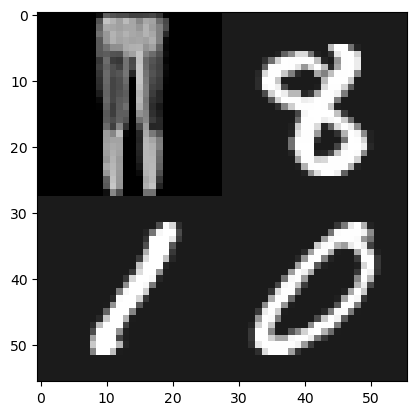

(10, 7, 7)
(14, 35)


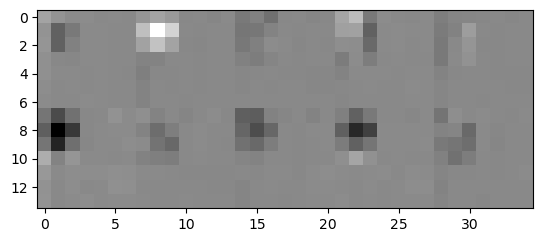

In [114]:
"""
Visualize.
"""
# TODO: Choose a correctly classified image and visualize it
predloader = DataLoader(testset, batch_size=64, shuffle=False)
model.eval() # Set the model to evaluation mode

"""
correct_img = None
while correct_img is None:
    batch, label = next(iter(predloader))
    batch = batch.to(device)
    label = label.to(device)
    pred = model(batch)
    correct_imgs = batch[torch.argmax(pred,dim=1) == label]
    if len(correct_imgs):
        correct_img = correct_imgs[0]
"""

batch, label = next(iter(predloader))
batch = batch.to(device)
label = label.to(device)
    
correct_idx = 3
correct_img = batch[correct_idx] # pre-calculated correct image
print(correct_img.shape)
plt.imshow(correct_img.squeeze(), cmap="gray")
plt.show()

activated_img = model.visualize(correct_img).detach().numpy()
print(activated_img.shape)
grid_img = np.zeros((14, 35))
for i in range(2):
    for j in range(5):
        idx = (i * 5) + j
        grid_img[i * 7: (i + 1) * 7, j * 7: (j + 1) * 7] = activated_img[idx, :, :]
print(grid_img.shape)
plt.imshow(grid_img, cmap="gray")
plt.show()